## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
new_dir = 'split/'

train_folder = os.path.join(new_dir, 'train')
train_update_folder = os.path.join(new_dir, 'train_oct2020')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')
train_update_pneumonia = os.path.join(train_update_folder, 'PNEUMONIA_oct2020')
train_update_normal = os.path.join(train_update_folder, 'NORMAL_oct2020')

test_folder = os.path.join(new_dir, 'test')
test_update_folder = os.path.join(new_dir, 'test_oct2020')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')
test_update_pneumonia = os.path.join(test_update_folder, 'PNEUMONIA_oct2020')
test_update_normal = os.path.join(test_update_folder, 'NORMAL_oct2020')

val_folder = os.path.join(new_dir, 'validation')
val_update_folder = os.path.join(new_dir, 'validation_oct2020')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')
val_update_pneumonia = os.path.join(val_update_folder, 'PNEUMONIA_oct2020')
val_update_normal = os.path.join(val_update_folder, 'NORMAL_oct2020')

In [3]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_update_folder, 
    #classes=['NORMAL_oct2020','PNEUMONIA_oct2020'],
    # All images will be resized to 210x210
    target_size=(210, 210), 
    batch_size = 2438)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 2438 images belonging to 2 classes.


In [4]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_update_folder,
    #classes=['NORMAL_oct2020','PNEUMONIA_oct2020'],
    target_size=(210, 210), 
    batch_size = 364)
    #,
    #class_mode='binary')
    #,
    #shuffle=False)

validating data:
Found 364 images belonging to 2 classes.


In [5]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_update_folder,
    #classes=['NORMAL_oct2020','PNEUMONIA_oct2020'],
    target_size=(210, 210), 
    batch_size = 274,
    #class_mode='binary',
    shuffle=False) 

testing data:
Found 274 images belonging to 2 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

(2438, 210, 210, 3)
(274, 210, 210, 3)
(364, 210, 210, 3)
(2438, 2)
(274, 2)
(364, 2)


In [8]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(2438, 1)
(274, 1)
(364, 1)


In [9]:
train_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [10]:
train_generator.class_indices

{'NORMAL_oct2020': 0, 'PNEUMONIA_oct2020': 1}

In [11]:
# PNEUMONIA
print(train_y[train_y==0].shape[0]/train_y.shape[0])
print(test_y[test_y==0].shape[0]/test_y.shape[0])
print(val_y[val_y==0].shape[0]/val_y.shape[0])

0.5
0.5
0.37637362637362637


In [12]:
# NORMAL
print(train_y[train_y==1].shape[0]/train_y.shape[0])
print(test_y[test_y==1].shape[0]/test_y.shape[0])
print(val_y[val_y==1].shape[0]/val_y.shape[0])

0.5
0.5
0.6236263736263736


In [13]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Designing CNN Model w/ Early Stopping

Now it's time to design your CNN using Keras! Remember a few things when doing this: 

- You should alternate convolutional and pooling layers
- You should have later layers have a larger number of parameters in order to detect more abstract patterns
- Add some final dense layers to add a classifier to the convolutional base 
- Compile this model 

In [14]:
# Your code here; design and compile the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', 
                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-3), input_shape=(210, 210, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid',
                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 208, 208, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 104, 104, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 102, 102, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       1

* Import `EarlyStopping` and `ModelCheckpoint` from keras.callbacks
* Define a list, `early_stopping`:
    * Monitor `val_loss` and continue training for 10 epochs before stopping
    * Save the best model while monitoring `val_loss`

In [16]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='./cnn1_chest_xray_ALL_data_BestModel_'+str(date.today())+'.h5', 
                                  monitor='val_loss', save_best_only=True)]

In [17]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

## Training and Evaluating the Model

Remember that training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is apt to take hours to train on a high-end laptop. Using 30 epochs and 8 layers (alternating between convolutional and pooling), my model took about 14 hours to run on a 9 years old macbook pro (Late 2011, macOS High Sierra, v.10.13.6). That is, I set my model to run the training epochs overnight.  

In [18]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
history = model.fit(train_images, train_y, epochs=200, callbacks=early_stopping, 
                    batch_size=250, validation_data=(val_images, val_y))
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-10-15 19:37:22.788488
Epoch 1/200
10/10 [==============================] - 1853s 185s/step - loss: 0.9912 - accuracy: 0.5369 - val_loss: 0.8911 - val_accuracy: 0.4121
Epoch 2/200
10/10 [==============================] - 1104s 110s/step - loss: 0.7618 - accuracy: 0.6891 - val_loss: 0.5604 - val_accuracy: 0.8022
Epoch 3/200
10/10 [==============================] - 755s 75s/step - loss: 0.5565 - accuracy: 0.8347 - val_loss: 0.4079 - val_accuracy: 0.9148
Epoch 4/200
10/10 [==============================] - 702s 70s/step - loss: 0.4362 - accuracy: 0.8843 - val_loss: 0.4181 - val_accuracy: 0.8956
Epoch 5/200
10/10 [==============================] - 709s 71s/step - loss: 0.4036 - accuracy: 0.8983 - val_loss: 0.3551 - val_accuracy: 0.9176
Epoch 6/200
10/10 [==============================] - 696s 70s/step - loss: 0.3671 - accuracy: 0.9163 - val_loss: 0.2885 - val_accuracy: 0.9341
Epoch 7/200
10/10 [==============================] - 714s 71s/step - loss: 0.3075

In [ ]:
#!pip install pydot

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot_CNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
#from IPython.display import Image, SVG
#Image(filename='model_plot_CNN.png')
##SVG(keras.utils.vis_utils.model_to_dot(model).create(prog=dot, format=svg))

## CNN Model Evaluation : Accuracy, ROC Curve and AUC 

Now use the test set to perform an evaluation on the model of choice. 

In [19]:
# Load the best (saved) model
saved_model = load_model('./cnn1_chest_xray_ALL_data_BestModel_2020-10-15.h5')

In [20]:
results_train = model.evaluate(train_images, train_y)

77/77 [==============================] - 91s 1s/step - loss: 0.0929 - accuracy: 0.9979


In [21]:
results_test = model.evaluate(test_images, test_y)

9/9 [==============================] - 10s 1s/step - loss: 0.4639 - accuracy: 0.9088


In [22]:
best_results_train = saved_model.evaluate(train_images, train_y)

77/77 [==============================] - 148s 2s/step - loss: 0.1291 - accuracy: 0.9881


In [23]:
best_results_test = saved_model.evaluate(test_images, test_y)

9/9 [==============================] - 16s 2s/step - loss: 0.3888 - accuracy: 0.9051


In [24]:
results_train

[0.09288112074136734, 0.9979491233825684]

In [25]:
results_test

[0.46389785408973694, 0.9087591171264648]

In [26]:
best_results_train

[0.12906377017498016, 0.9881049990653992]

In [27]:
best_results_test

[0.3887743651866913, 0.9051094651222229]

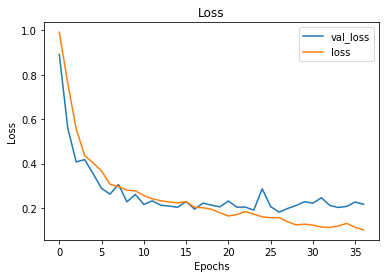

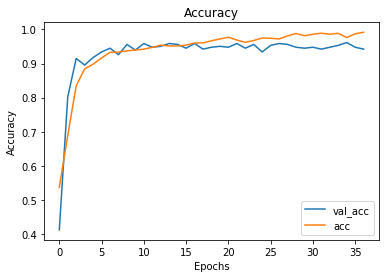

In [28]:
visualize_training_results(history)

Make predictions on the validation data set. When using generators to make predictions, we must first turn off shuffle (the same as what we have done with creating the validation data-set).

In [29]:
preds = saved_model.predict(test_images)

In [30]:
type(preds)

numpy.ndarray

In [31]:
preds.shape

(274, 1)

In [32]:
test_y.shape

(274, 1)

In [33]:
pred_class = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [34]:
pred_class.shape

(274, 1)

In [35]:
pred_binary_class = (model.predict(test_images) > 0.5).astype("int32")
pred_binary_class.shape

(274, 1)

In [36]:
# test set
true_classes = test_generator.classes
print(true_classes)
class_labels = list(test_generator.class_indices.keys())
class_labels

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


['NORMAL_oct2020', 'PNEUMONIA_oct2020']

In [37]:
accuracy = accuracy_score(test_y, preds.round())
accuracy

0.9051094890510949

In [38]:
precision = precision_score(test_y, preds.round())
precision

0.8490566037735849

In [39]:
recall = recall_score(test_y, preds.round())
recall

0.9854014598540146

In [40]:
f1 = f1_score(test_y, preds.round())
f1

0.9121621621621622

In [41]:
auc_value = roc_auc_score(test_y, preds)
auc_value

0.9823112579253024

In [42]:
fpr, tpr, threshold = roc_curve(test_y, preds)

In [43]:
roc_auc = auc(fpr, tpr)

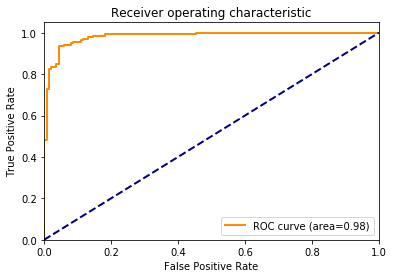

In [44]:
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

In [45]:
report = classification_report(test_y, preds.round(), target_names=class_labels)
print(report)

                   precision    recall  f1-score   support

   NORMAL_oct2020       0.98      0.82      0.90       137
PNEUMONIA_oct2020       0.85      0.99      0.91       137

         accuracy                           0.91       274
        macro avg       0.92      0.91      0.90       274
     weighted avg       0.92      0.91      0.90       274



In [46]:
cnf_matrix = confusion_matrix(y_true=test_y, y_pred=preds.round())
np.set_printoptions(precision=2)
print(cnf_matrix)

[[113  24]
 [  2 135]]


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[113  24]
 [  2 135]]


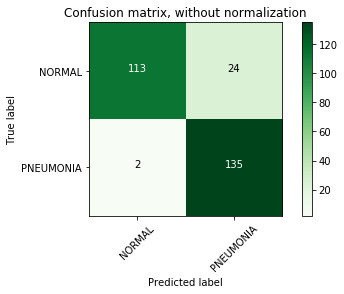

In [49]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cm_plot_labels, title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.82 0.18]
 [0.01 0.99]]


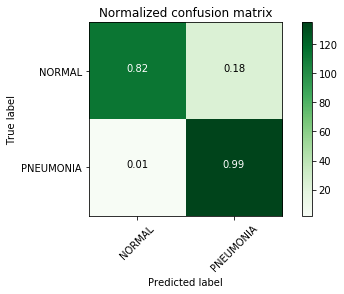

In [50]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

## Saving history in CSV

In [51]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = 'cnn1_chest_xray_ALL_data_BestModel'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f) 
    
# or save to json:  
hist_json_file = 'cnn1_chest_xray_ALL_data_BestModel'+str(date.today())+'_history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## Saving history in PICKLE

In [52]:
with open('/Users/macbookpro/dsc-building-a-cnn-from-scratch-onl01-dtsc-ft-052620/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)